In [5]:
from NSGPy import nsgp, plot_nsgp_1d, plot_nsgp_2d, nsgp_posterior, NSGP, plot_kernel_1d
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import gmean
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

class TrueModel:
    def __init__(self, x, f):
        self.x = x
        self.f = f

def f_noisy(x1):
    """Generates a noisy function with added random noise."""
    return np.sin((x1 * 6) ** 4 * 0.01) + (1 - x1) + (np.random.random(x1.shape) - 0.5) * 0.5 * (1 - x1)

def f(x1):
    """Defines a smooth function without noise."""
    return np.sin((x1 * 6) ** 4 * 0.01) + (1 - x1)

def denormalise(gp, ft=0, ftstd=0, lt=0, st=0, ot=0):
    """
    Denormalises the given parameters using the stored normalization factors in 'pars'.
    
    Parameters
    ----------
    gp : object
        GP model instance containing normalisation parameters
    ft : 
        Function values to denormalise (default 0)
    ftstd : 
        Function standard deviation to denormalise (default 0)
    lt : 
        Lengthscale posterior mean (default 0)
    st : 
        Signal variance posterior mean (default 0)
    ot : 
        Noise variance posterior mean (default 0)

    Returns
    -------
    xtr : 
        Denormalised training inputs
    ytr : 
        Denormalised training outputs
    ft : 
        Denormalised function values
    ftstd : 
        Denormalised function standard deviations
    lt : 
        Denormalised lengthscale
    st : 
        Denormalised signal variance
    ot : 
        Denormalised noise variance
    """
    # Denormalisation
    xtr = gp.normalized_inputs * gp.input_range + gp.input_min
    ytr = gp.normalized_outputs * gp.output_scale + gp.output_mean
    ft = ft * gp.output_scale + gp.output_mean
    ftstd = ftstd * gp.output_scale
    lt = lt * gmean(gp.input_range)
    ot = ot * gp.output_scale
    st = st * gp.output_scale

    return xtr, ytr, ft, ftstd, lt, st, ot

In [6]:
#==========================================
# Data Generation
#==========================================
#Xt = np.linspace(0, 1, 19).reshape(-1,1)  # 10 evenly spaced points between 0 and 1
Xt = np.array([0.1, 0.25, 0.37, 0.5, 0.63, 0.75, 0.81, 0.9, 0.98]).reshape(-1,1)  # Custom points for training
y_pred1D = f(Xt).reshape(-1,1)  # Compute corresponding function values

# Generate test data for true function visualization (optional)
Xt_true = np.linspace(0, 1, 100).reshape(-1,1)  # 100 test points for smooth function visualization
y_true1D = f(Xt_true).reshape(-1,1)  # Compute true function values
truemodel = TrueModel(Xt_true, y_true1D)  # Store true model data for comparison

#==========================================
# Stationary GP model
#==========================================

kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gaussian_process.fit(Xt, y_pred1D)
gaussian_process.kernel_

mean_prediction, std_prediction = gaussian_process.predict(Xt_true, return_std=True)

#==========================================
# NSGP Model
#==========================================
lgp = NSGP()

# Define hyperparameters for the NSGP model (optional)
hyperparameters = {
    "init_lengthscale": 0.05,      # Initial lengthscale for the kernel
    "init_signal_variance": 0.3,   # Initial signal variance
    "init_noise_variance": 0.05,   # Initial noise variance
    "beta_lengthscale": 0.2,       # Controls variation of lengthscale
    "beta_signal_variance": 0.2,   # Controls variation of signal variance
    "beta_noise_variance": 0.3,    # Controls variation of noise variance
    "alpha_lengthscale": 1,        # Alpha parameter for lengthscale
    "alpha_signal_variance": 1,    # Alpha parameter for signal variance
    "alpha_noise_variance": 1,     # Alpha parameter for noise variance
    "verbose_output": False,
}

lgp.set_params(**hyperparameters)

# Set the optimization parameters (optional)
lgp.optimizer(optimizer="grad", random_restarts=5, max_iteration=5000)

# Train the NSGP model with training data
# The last argument "ls" specifies which nonstationary functions to learn (lengthscale, signal variance)
lgp.fit(Xt, y_pred1D, "ls")

#==========================================
# NSGP Plot setup
#==========================================
gp = lgp.gp
squares = 1
cols = np.array([[248, 118, 109], [0, 186, 56], [97, 156, 255]]) / 255
if truemodel:
    xt = np.linspace(((min(truemodel.x) - gp.input_min) / gp.input_range).item(), ((max(truemodel.x) - gp.input_min) / gp.input_range).item(), 250)[:, None]
else:
    xt = np.linspace(-0.1, 1.1, 250)[:, None]
ft, ftstd, lt, st, ot = nsgp_posterior(gp, xt)
xt = xt * gp.input_range + gp.input_min
xtr, ytr, *_ = denormalise(gp)


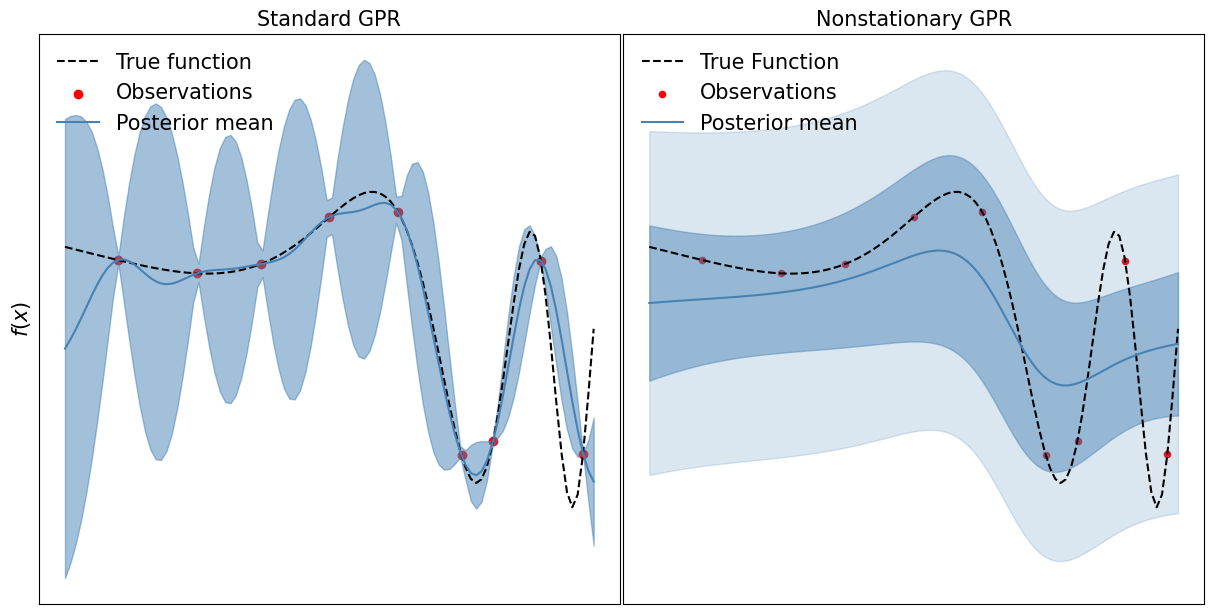

In [12]:
import matplotlib.pyplot as plt
import numpy as np

font_size = 15

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)  # A4 column width

# === Subplot 1: Standard GPR ===
axs[0].plot(Xt_true, y_true1D, '--', color='black', label="True function" )
axs[0].scatter(Xt, y_pred1D, label="Observations", color='red')
axs[0].plot(Xt_true, mean_prediction, color='steelblue', label="Posterior mean")
axs[0].fill_between(
    Xt_true.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.5,
#    label=r"95% confidence interval",
    color='steelblue'
)
axs[0].set_title("Standard GPR", fontsize=font_size)
axs[0].tick_params(labelbottom=False)  # Remove tick labels
axs[0].set_xticks([])          # Remove tick marks (optional)
axs[0].tick_params(labelleft=False)    # Hide y tick labels
axs[0].set_yticks([])                  # Remove tick marks (optional)
axs[0].set_ylabel("$f(x)$", fontsize=font_size)
axs[0].legend(fontsize=font_size, loc="upper left", frameon=False)
axs[0].tick_params(labelsize=font_size)
axs[0].grid(True)

# === Subplot 2: Nonstationary GP ===
axs[1].plot(truemodel.x, truemodel.f, '--', color='black', label='True Function')
axs[1].scatter(xtr, ytr, color='red', s=20, label='Observations')
axs[1].plot(xt, ft, color='steelblue', label='Posterior mean')
axs[1].fill_between(xt.flatten(), ft[:, 0] - 2 * ftstd, ft[:, 0] + 2 * ftstd, color='steelblue', alpha=0.45)
axs[1].fill_between(xt.flatten(), ft[:, 0] - 2 * np.sqrt(ftstd**2 + ot**2),
                    ft[:, 0] + 2 * np.sqrt(ftstd**2 + ot**2), color='steelblue', alpha=0.2)

axs[1].set_title("Nonstationary GPR", fontsize=font_size)
axs[1].tick_params(labelbottom=False)  # Remove tick labels
axs[1].set_xticks([])          # Remove tick marks (optional)
axs[1].set_yticks([])                  # Remove tick marks (optional)
axs[1].legend(fontsize=font_size, loc="upper left", frameon=False)
axs[1].tick_params(labelsize=font_size)
axs[1].grid(True)


# Final layout and save
plt.tight_layout(pad = 0.2)
#plt.savefig("GP.pgf", bbox_inches='tight', dpi=600)
plt.show()